In [1]:
import torch
import torch.nn as nn
from nn import LinearBlock, Conv2dBlock, ConvTranspose2dBlock
from torchsummary import summary
import json
import torch.utils.data as data
import h5py
import pickle as pkl
import torchvision.transforms as transforms
from jmetal.algorithm.multiobjective import NSGAII
from jmetal.operator import SBXCrossover, PolynomialMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.core.problem import FloatProblem
from jmetal.core.solution import FloatSolution
from jmetal.lab.experiment import Experiment, Job, generate_summary_from_experiment
from jmetal.core.quality_indicator import *
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# custom scripts
from my_attgan import AttGAN
from my_mivolo_inference import mivolo_inference
from my_mivolo_inference import predictor
from cf_utils import *
from generate_gender_cfs import AttGanPlausibleCounterfactualProblem
from data import Custom
from data import CelebA_HQ_custom

Model summary (fused): 112 layers, 68,125,494 parameters, 0 gradients, 257.4 GFLOPs


In [2]:
# Load settings

image_size = 384
with open('./384_shortcut1_inject1_none_hq/setting.txt', 'r') as f:
    gan_args = json.load(f)
    
# Load AttGAN

attgan = AttGAN(gan_args)
attgan.load('./384_shortcut1_inject1_none_hq/weights.149.pth')
attgan.eval()

In [35]:
# Load valid CFs

with open('./Counterfactuals/Front_10374_1.pkl', 'rb') as f:
  pareto_front = pkl.load(f)
  factual_img = pkl.load(f)
  factual_atts = pkl.load(f)
  runtime_in_seconds = pkl.load(f)
  experiment_metadata = pkl.load(f)
  
raw_x_data, raw_y_data, raw_z_data, new_preds, new_attributes, generated_cfs, dominance_ranking, crowding_distances = unpack_front(pareto_front)

In [36]:
# Valid CFs

raw_x_data, raw_y_data, raw_z_data, new_preds, new_attributes, generated_cfs, dominance_ranking, crowding_distances = unpack_front(pareto_front) 

In [37]:
# Valid CFs

valid_cfs_idx = [i for i, y in enumerate(raw_y_data) if y < 0.5]
valid_cf_images = torch.stack([generated_cfs[i] for i in valid_cfs_idx]).squeeze(1)

# x en 0 - no hay cambios - se cumple el objectivo ---> 1 - normalized(x). 1 es que no hay cambios
# y en 0 - cambia la prediccion - se cumple el objetivo ---> 1 - normalized(y). 1 es que cambia la prediccion
# z en 0 - es plausible - se cumple el objetivo ---> 1 - normalized(z). 1 es que es plausible

raw_x_data = [raw_x_data[i] for i in valid_cfs_idx]
raw_y_data = [raw_y_data[i] for i in valid_cfs_idx]
raw_z_data = [raw_z_data[i] for i in valid_cfs_idx]
new_preds = [new_preds[i] for i in valid_cfs_idx]

x_data = min_max(raw_x_data).reshape(-1) # (n, 1)
y_data = min_max(raw_y_data).reshape(-1)
z_data = min_max(raw_z_data).reshape(-1)
    
x_data = 1 - x_data # Ahora la variable en 1 representa que NO hay cambios
y_data = 1 - y_data # Ahora la variable en 1 representa que se cambia la prediccion
z_data = 1 - z_data # Ahora la variable en 1 representa que la imagen es plausible

You were originally predicted to be 99.72638% Female, but now you are predicted to be 1.00573% Female due to the following changes: 
You are predicted to have 24.00% of the Black_Hair attribute, whereas your Counterfactual has 57.00%
You are predicted to have 75.00% of the Mouth_Slightly_Open attribute, whereas your Counterfactual has 47.00%
You are predicted to have 41.00% of the Male attribute, whereas your Counterfactual has 66.00%
You are predicted to have 63.00% of the Brown_Hair attribute, whereas your Counterfactual has 43.00%
You are predicted to have 34.00% of the Eyeglasses attribute, whereas your Counterfactual has 52.00%


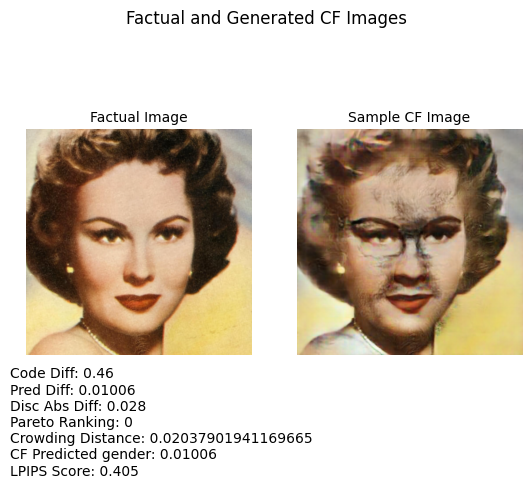

In [38]:
# Generate explanation for a single factual iamge

# Sample CFs

factual_image = factual_img
factual_gender_prob, factual_age = mivolo_inference(factual_image, True)
with torch.no_grad():
  factual_d_score, dc_real = attgan.D(factual_image)

random_idx = np.random.randint(len(valid_cfs_idx))
cf_idx = random_idx
base_attrs = gan_args.get('attrs')

with torch.no_grad():
  img_fake = valid_cf_images[cf_idx].unsqueeze(0)
  att_fake = new_attributes[cf_idx].unsqueeze(0)
  modified_indices = ((att_fake != -torch.tensor(0.5)) * (att_fake != -torch.tensor(0))).squeeze(0).nonzero()
  modified_atts = [(base_attrs[i], att_fake[:, i].item()) for i in modified_indices]
  code_difference = raw_x_data[cf_idx]
  pred_difference = raw_y_data[cf_idx]
  disc_difference = raw_z_data[cf_idx]
  pareto_rank = dominance_ranking[cf_idx]
  cw_distance = crowding_distances[cf_idx]
  cf_gender_prob = new_preds[cf_idx]
  
  img_factual = normalize_0_1(factual_image).squeeze(0).permute(1, 2, 0).numpy()
  img_cfactual = normalize_0_1(img_fake).squeeze(0).permute(1, 2, 0).numpy()
  lpips = LearnedPerceptualImagePatchSimilarity(net_type='alex', reduction='none') # Alex is faster than vgg
  lpips_distance = lpips(factual_image, img_fake).item()
  
  %matplotlib inline
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.imshow(img_factual)
  ax2.imshow(img_cfactual)
  ax1.title.set_text('Factual Image')
  ax1.title.set_fontsize(10)
  ax2.title.set_text('Sample CF Image')
  ax2.title.set_fontsize(10) 
  ax1.axis('off')
  ax2.axis('off')
  fig.suptitle('Factual and Generated CF Images')
  plt.figtext(0.10, 0.01, f"""Code Diff: {round(code_difference, 2)}\nPred Diff: {round(pred_difference, 5)}\nDisc Abs Diff: {round(disc_difference, 3)}\nPareto Ranking: {pareto_rank}\nCrowding Distance: {cw_distance}\nCF Predicted gender: {round(new_preds[cf_idx], 5)}\nLPIPS Score: {round(lpips_distance, 3)}""")
  generate_text_explanations(base_attrs, factual_gender_prob, cf_gender_prob, 'Female', dc_real, att_fake, top_att = 5)

/Users/arielmalowany/Desktop/Learning/COUNT-GEN/COUNT-GEN-REPLICABILITY-REPO/cf_utils.py:213: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  data_ax.scatter(idx, value,
/Users/arielmalowany/Desktop/Learning/COUNT-GEN/COUNT-GEN-REPLICABILITY-REPO/cf_utils.py:217: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  front_ax.scatter3D(x_data[idx], y_data[idx], z_data[idx],


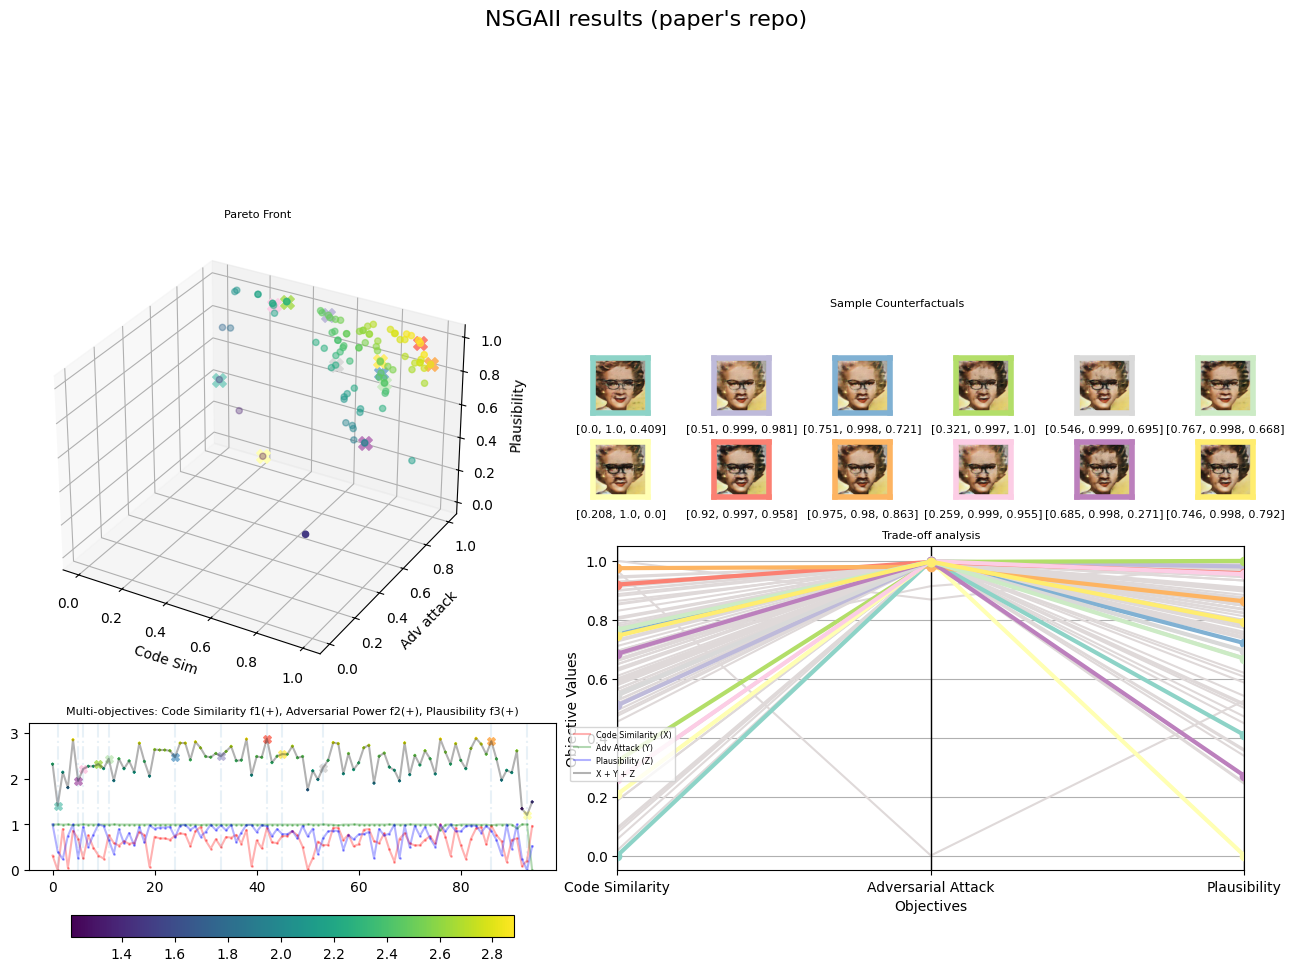

In [39]:
# Plot Figure from the Count-Gen Paper

plot_fig_from_paper(x_data, y_data, z_data, generated_cfs, valid_cf_n = len(valid_cf_images), n_row = 2, n_col = 6)

In [40]:
# Individual Plots

# Sample CF indexes

n_cfs = len(valid_cf_images)
n_rows = 5
n_cols = 2
fig_size = 1 * [6.4, 4.8]
cf_idxs = get_counterfactuals(n_cfs, n_rows, n_cols)
highlight_cmap = cm.get_cmap('tab10')

/var/folders/5j/bzx1pm2n5fg14pqsndlhvb700000gn/T/ipykernel_72522/2584416882.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  highlight_cmap = cm.get_cmap('tab10')


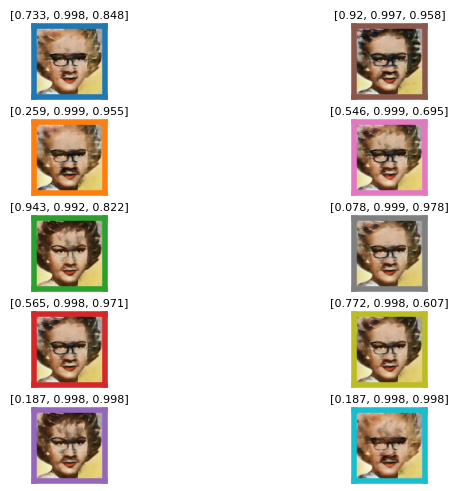

In [41]:
# Plot Sample CFs

fig = plt.figure(figsize = fig_size, constrained_layout=True)
grid = fig.add_gridspec(n_rows, n_cols)
counterfactuals_ax = plot_cf_images(fig, grid, n_rows, n_cols)

for i, idx in enumerate(cf_idxs):
  counterfactuals_ax[i].imshow(min_max(generated_cfs[idx].squeeze(0).permute(1, 2, 0).cpu().numpy()))
  counterfactuals_ax[i].set_title(f"""[{round(x_data[idx], 3)}, {round(y_data[idx], 3)}, {round(z_data[idx], 3)}]""", loc = 'center', y = 1, fontsize = 8)
  plt.setp(
    counterfactuals_ax[i].spines.values(),
    color = highlight_cmap(i),
    linewidth = 4
  )

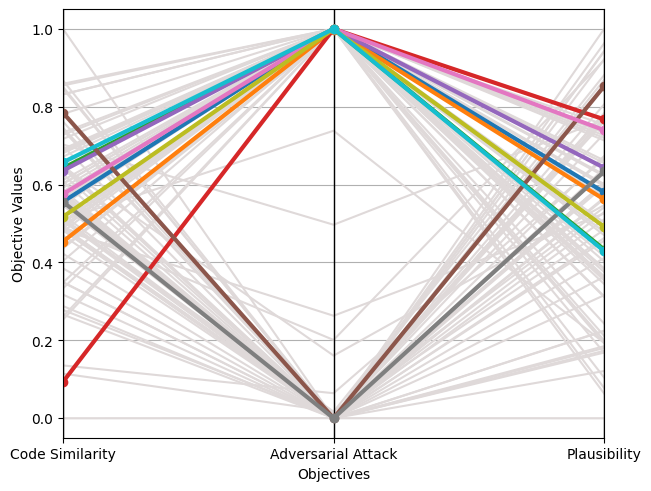

In [40]:
# Plot Parallel Coords

fig = plt.figure(figsize = fig_size, constrained_layout=True)
parallel_coords = fig.add_subplot()
plot_parallel_coordinates(parallel_coords, x_data, y_data, z_data, highlight_cmap, cf_idxs)

/var/folders/5j/bzx1pm2n5fg14pqsndlhvb700000gn/T/ipykernel_5598/1818844719.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  front_ax.scatter3D(


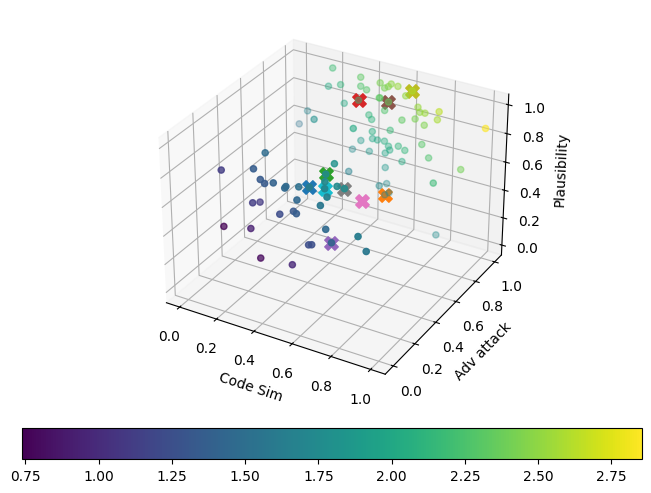

In [118]:
# Plot 3D

fig = plt.figure(figsize = fig_size, constrained_layout=True)

front_ax = fig.add_subplot(projection='3d')

front_ax.set_xlabel('Code Sim')
front_ax.set_ylabel('Adv attack')
front_ax.set_zlabel('Plausibility')
_cs = front_ax.scatter3D(x_data, y_data, z_data, c=(x_data + y_data + z_data))
plt.colorbar(_cs, orientation="horizontal", ax=front_ax)

for i, idx in enumerate(cf_idxs):
  front_ax.scatter3D(
      x_data[idx], 
      y_data[idx], 
      z_data[idx],
      c = highlight_cmap(i),
      s = n_cfs,
      marker = 'X'
  )